# Feature importances

In this notebook we generate the feature importance results shown in Table 6.

Note that this notebook must be run twice, once with `DATASET` set to 0 and once with `DATASET` set to 1.

The results can be seen in the output of the "Show most important features" cell.

In [1]:
%matplotlib inline
import sys
import os
import time

import pandas as pd
import numpy as np

import CBECSLib
CBECSLib = reload(CBECSLib)

import itertools
from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

#sklearn base
import sklearn.base

#sklearn utility
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

#sklearn models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

#IPython utilities
from IPython.display import HTML,display
def show(html):
    display(HTML(html))

In [2]:
DATASET = 0

In [3]:
pbaLabels = CBECSLib.pbaLabels
pbaPlusLabels = CBECSLib.pbaPlusLabels

getDataset = CBECSLib.getDataset
getClassFrequencies = CBECSLib.getClassFrequencies
getDataSubset = CBECSLib.getDataSubset

# Print extended features

In [4]:
dataKey = {}
f = open("data/cbecs/2012_microdata_codebook.csv","r")
for line in f:
    key,value = map(str.strip,line.split("|"))
    if key!="":
        dataKey[key]=value
f.close()

In [5]:
X,Y,columnNames,classVals = getDataset(0,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

20 classes


In [6]:
for columnName in columnNames:
    if columnName in dataKey:
        print "%s,%s" % (columnName, dataKey[columnName])
    else:
        print columnName

FREESTN,Freestanding building
SQFT,Square footage
SQFTC,Square footage category
WLCNS,Wall construction material
RFCNS,Roof construction material
RFCOOL,Cool roof materials
RFTILT,Roof tilt
BLDSHP,Building shape
GLSSPC,Percent exterior glass
EQGLSS,Equal glass on all sides
NFLOOR,Number of floors
FLCEILHT,Floor to ceiling height
ATTIC,Attic
YRCON,Year of construction
YRCONC,Year of construction category
RENOV,Any renovations
RENADD,Addition or annex
RENRDC,Reduction of floorspace
RENCOS,Cosmetic improvements
RENINT,Interior wall re-configuration
RENRFF,Roof replacement
RENWLL,Exterior wall replacement
RENWIN,Window replacement
RENHVC,HVAC equipment upgrade
RENLGT,Lighting upgrade
RENPLB,Plumbing system upgrade
RENELC,Electrical upgrade
RENINS,Insulation upgrade
RENSAF,Fire, safety, or security upgrade
RENSTR,Structural upgrade
RENOTH,Other renovation
ONEACT,One activity in building
FACIL,On a multibuilding complex
GOVOWN,Government owned
OWNTYPE,Building owner
NOCC,Number of businesses

# Visualize Decision Tree

In [7]:
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image  

In [8]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = scaler.transform(X)


regressor = DecisionTreeRegressor()
regressor.fit(X_train,Y_train)

print "Training r2: ",r2_score(Y_train, regressor.predict(X_train))
print "Testing r2: ",r2_score(Y_test, regressor.predict(X_test))

20 classes
Training r2:  0.999999999603
Testing r2:  0.722845990405


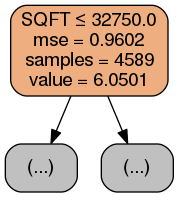

In [9]:
dot_data = export_graphviz(regressor, out_file=None, max_depth=0, feature_names=columnNames, filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

# Important Features

In [10]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = scaler.transform(X)

regressor = GradientBoostingRegressor()
regressor.fit(X_train,Y_train)

print "Training r2: ",r2_score(Y_train, regressor.predict(X_train))
print "Testing r2: ",r2_score(Y_test, regressor.predict(X_test))

20 classes
Training r2:  0.917702775063
Testing r2:  0.902711038105


# Show most important features

In [11]:
importances = regressor.feature_importances_

assert abs(np.sum(importances)-1) < 1e-5

k = 10
sortedImportancesWithIndices = sorted([(_,i) for i,_ in enumerate(importances)], reverse=True)

for i, (importance, index) in enumerate(sortedImportancesWithIndices[:k]):
    
    description = ""
    if columnNames[index] in dataKey:
        description = dataKey[columnNames[index]]
    else:
        description = columnNames[index]
    
    print "%02d\t%s\t%0.4f\t%s" % (i+1, columnNames[index], importance, description)

01	SQFT	0.1551	Square footage
02	NWKER	0.0718	Number of employees
03	WKHRS	0.0426	Total hours open per week
04	MONUSE	0.0419	Months in use
05	HDD65	0.0368	Heating degree days (base 65)
06	NGUSED	0.0319	Natural gas used
07	ZMFBTU	0.0311	Imputed major fuels consumption
08	HEATP	0.0304	Percent heated
09	PBA 6	0.0191	PBA 6
10	FKUSED	0.0186	Fuel oil/diesel/kerosene used


# Important features within PBA

In [12]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)


classOutputs = []

for i,classVal in enumerate(classOrdering):
    
    className = pbaLabels[classVal]
    numberOfSamples = classFrequencies[classVal]
    
    #if className!="Food service":
    #    continue
    
    startTime = float(time.time())
    print "%02d/%d\tRunning experiments for %s(n=%d)" % (i+1,len(classOrdering), className, numberOfSamples)
    print "-"*40
    X_temp, Y_temp, classVals_temp = CBECSLib.getDataSubsetWithClassvals(X,Y,classVals,classVal)
    
    rs = StratifiedShuffleSplit(n_splits=1, train_size=0.9, test_size=.1, random_state=0)
    train_index, test_index = next(rs.split(Y_temp,classVals_temp))

    X_train, X_test = X_temp[train_index], X_temp[test_index]
    Y_train, Y_test = Y_temp[train_index], Y_temp[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)    
    
    regressor = GradientBoostingRegressor()
    regressor.fit(X_train_scaled,Y_train)
    
    print "Training r2: ",r2_score(Y_train, regressor.predict(X_train_scaled))
    print "Testing r2: ",r2_score(Y_test, regressor.predict(X_test_scaled))

    print "-"*40
    print "-"*40
    
    importances = regressor.feature_importances_

    k = 15
    sortedImportancesWithIndices = sorted([(_,i) for i,_ in enumerate(importances)], reverse=True)

    for i, (importance, index) in enumerate(sortedImportancesWithIndices[:k]):
        description = ""
        if columnNames[index] in dataKey:
            description = dataKey[columnNames[index]]
        else:
            description = columnNames[index]
        print "%02d\t%s\t%0.4f\t%s" % (i+1, columnNames[index], importance, description)
    
    
    print "Finished experiments in %0.4f seconds" % (time.time()-startTime)
    print "-"*40
    print "-"*40
    print ""

20 classes
01/20	Running experiments for Office(n=1044)
----------------------------------------
Training r2:  0.963112044929
Testing r2:  0.927441534188
----------------------------------------
----------------------------------------
01	SQFT	0.1777	Square footage
02	NWKER	0.0689	Number of employees
03	HDD65	0.0365	Heating degree days (base 65)
04	YRCON	0.0344	Year of construction
05	CDD65	0.0245	Cooling degree days (base 65)
06	WKHRS	0.0240	Total hours open per week
07	FLUORP	0.0222	Percent lit by fluorescent
08	NGUSED	0.0207	Natural gas used
09	PCTERMN	0.0206	Number of computers
10	HEATP	0.0181	Percent heated
11	ZMFBTU	0.0173	Imputed major fuels consumption
12	LTOHRP	0.0171	Percent lit when open
13	LAPTPN	0.0161	Number of laptops
14	MAINHT	0.0156	Main heating equipment
15	FACIL	0.0152	On a multibuilding complex
Finished experiments in 0.4405 seconds
----------------------------------------
----------------------------------------

02/20	Running experiments for Education(n=580)
-----

Training r2:  0.998222926417
Testing r2:  0.895043954213
----------------------------------------
----------------------------------------
01	SQFT	0.1334	Square footage
02	WKHRS	0.0595	Total hours open per week
03	CDD65	0.0405	Cooling degree days (base 65)
04	MONUSE	0.0331	Months in use
05	NOCC	0.0300	Number of businesses
06	WATR	0.0300	Energy used for water heating
07	NWKER	0.0300	Number of employees
08	FLATC	0.0263	Flat screen category
09	COOLP	0.0246	Percent cooled
10	ZMFBTU	0.0236	Imputed major fuels consumption
11	WLCNS	0.0229	Wall construction material
12	LAPTPN	0.0217	Number of laptops
13	PCTERMN	0.0198	Number of computers
14	BLDSHP	0.0189	Building shape
15	LAPTPC	0.0180	Number of laptops category
Finished experiments in 0.1259 seconds
----------------------------------------
----------------------------------------

13/20	Running experiments for Food sales(n=111)
----------------------------------------
Training r2:  0.998715100762
Testing r2:  0.160039672263
------------------